# Import

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

#===========================

: 

# Visualisation of the datasets 

In [ ]:
# print the organisation of the datasets folder until the files using os.walk
import os

for root, dirs, files in os.walk('datasets'):
    level = root.replace('datasets', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)

        
#===========================

In [ ]:
train_data = np.load(f'../datasets/UTS/WSD/1/train.npy')
print(train_data.shape)
print(train_data[0])
print(type(train_data))

(18235,)
50.0833320618
<class 'numpy.ndarray'>


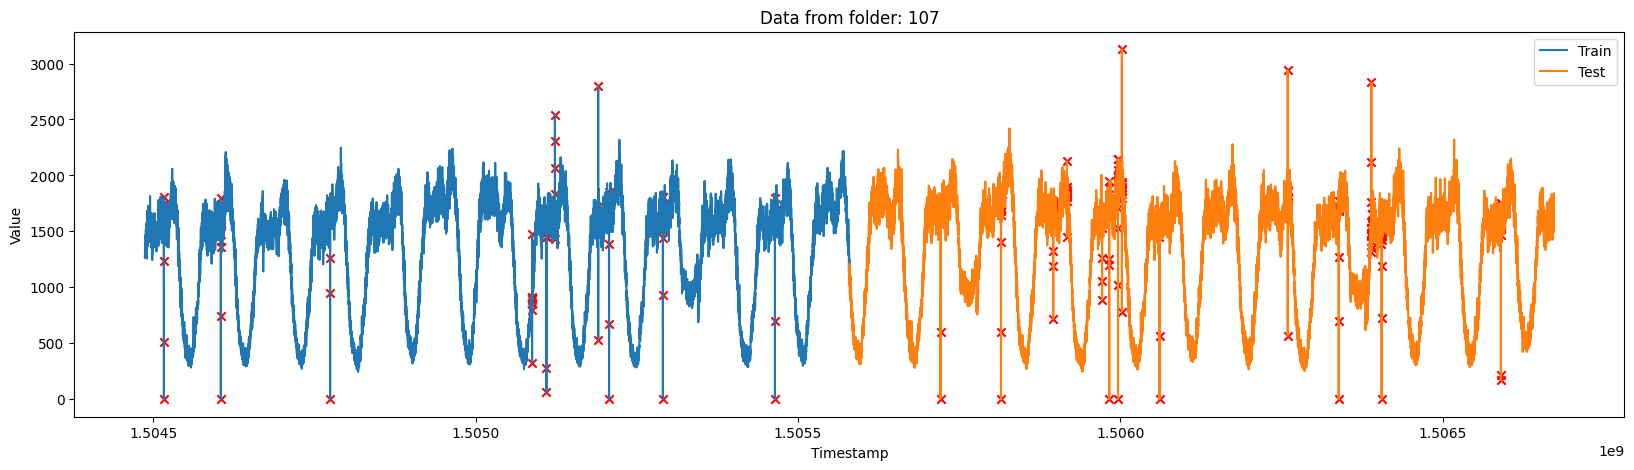

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 5 random folders
folders = os.listdir('../datasets/UTS/WSD')
folders = random.sample(folders, 5)
folders = [107]
# Plot the train.npy and test.npy files in each selected folder
for folder in folders:
    train_data = np.load(f'../datasets/UTS/WSD/{folder}/train.npy')
    print
    test_data = np.load(f'../datasets/UTS/WSD/{folder}/test.npy')
    
    train_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/train_timestamp.npy')
    test_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/test_timestamp.npy')
    
    # Plot the train and test data in one figure using different colors
    plt.figure(figsize=(20, 5))
    plt.plot(train_timestamp, train_data, label='Train')
    plt.plot(test_timestamp, test_data, label='Test')
    
    # Plot anomalies as points in red
    train_label = np.load(f'../datasets/UTS/WSD/{folder}/train_label.npy')
    test_label = np.load(f'../datasets/UTS/WSD/{folder}/test_label.npy')
    
    for i, label in enumerate(train_label):
        if label:
            plt.scatter(train_timestamp[i], train_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
    for i, label in enumerate(test_label):
        if label:
            plt.scatter(test_timestamp[i], test_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
            
    plt.title(f"Data from folder: {folder}")
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    



In [ ]:
    
#===========================
# compute the mean and std of the train data in the folder datasets/UTS/WSD/1
train_data = np.load('../datasets/UTS/WSD/1/train.npy')
mean = np.mean(train_data)
std = np.std(train_data)
print(mean, std)

#===========================
# Is train_data a 1D array or a 2D array?
print(train_data.ndim)

# In the variable data save = (train_data as a Tensor, train timestamp as a Tensor)
data = (torch.tensor(train_data), torch.tensor(train_timestamp))
print(data[0].shape, data[1].shape)
print(data)

36.78820118134014 11.438011591627744
1
torch.Size([18235]) torch.Size([18213])
(tensor([50.0833, 48.6667, 46.0833,  ..., 22.5000, 23.3000, 23.9000],
       dtype=torch.float64), tensor([1.5045e+09, 1.5045e+09, 1.5045e+09,  ..., 1.5056e+09, 1.5056e+09,
        1.5056e+09], dtype=torch.float64))


In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader( data , batch_size=32, shuffle=False, drop_last=True)

print(len(dataloader))
print(type(dataloader))
print(dataloader.batch_size)

for step, batch in enumerate(dataloader):
    print(step, batch[0].shape)

0
<class 'torch.utils.data.dataloader.DataLoader'>
32


# Model debugging

In [ ]:
import ddpm_Time_Series_copy
#!python ddpm_Time_Series_point_wize.py --data_path ../datasets/UTS/WSD/1 --output_dir output --num_epochs 1 --train_batch_size 512 --eval_batch_size 512 

# Visualisation of adding noise

In [ ]:

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset
from ddpm_Time_Series_copy import TCN 
from ddpm_Time_Series_copy import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding



In [ ]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 28,
  "eval_batch_size": 28,
  "num_epochs": 1,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1001,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 1,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)



In [ ]:

input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        print("Showing input and noisy data")
    
    progress_bar.close()


c:\Users\Ines\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


0it [00:00, ?it/s]:00, ?it/s]
Epoch 0: : 0it [00:00, ?it/s]


In [ ]:
#!pip install opensimplex

Explanation:
Constructor: Initializes the parameters similar to the original NoiseScheduler class.
generate_simplex_noise_like Method: Generates a tensor of Simplex noise with the same shape as the input tensor.
step Method: Uses Simplex noise instead of Gaussian noise for the variance term.
add_noise Method: Unchanged, it adds noise to the input data.
This new class SimplexNoiseScheduler will generate and use Simplex noise for the noise addition and sampling steps. The noise generation is done using the noise library's pnoise3 function, which generates 3D Perlin noise (Simplex noise). Adjust the noise generation as needed for your specific application and noise characteristics.

In [ ]:
import torch
import torch.nn.functional as F
from opensimplex import OpenSimplex

class SimplexNoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)
        
        self.simplex = OpenSimplex(seed=42)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = self.generate_simplex_noise_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def generate_simplex_noise_like(self, tensor):
        shape = tensor.shape
        simplex_noise = torch.zeros_like(tensor)
        for i in range(shape[0]):
            for j in range(shape[1]):
                simplex_noise[i, j] = self.simplex.noise2(i, j)
        return simplex_noise

    def __len__(self):
        return self.num_timesteps


In [1]:
sequence_length = 18200
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        break

NameError: name 'TimeSeriesDataset' is not defined

# Reconstruction steps visualisation :

In [68]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 28,
  "eval_batch_size": 28,
  "num_epochs": 10,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1001,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)

## Ajout de buits de manière random et départ d'un step totalement random: 

Training model...


Epoch 1: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Sampling: 100%|██████████| 1001/1001 [06:01<00:00,  2.77it/s]


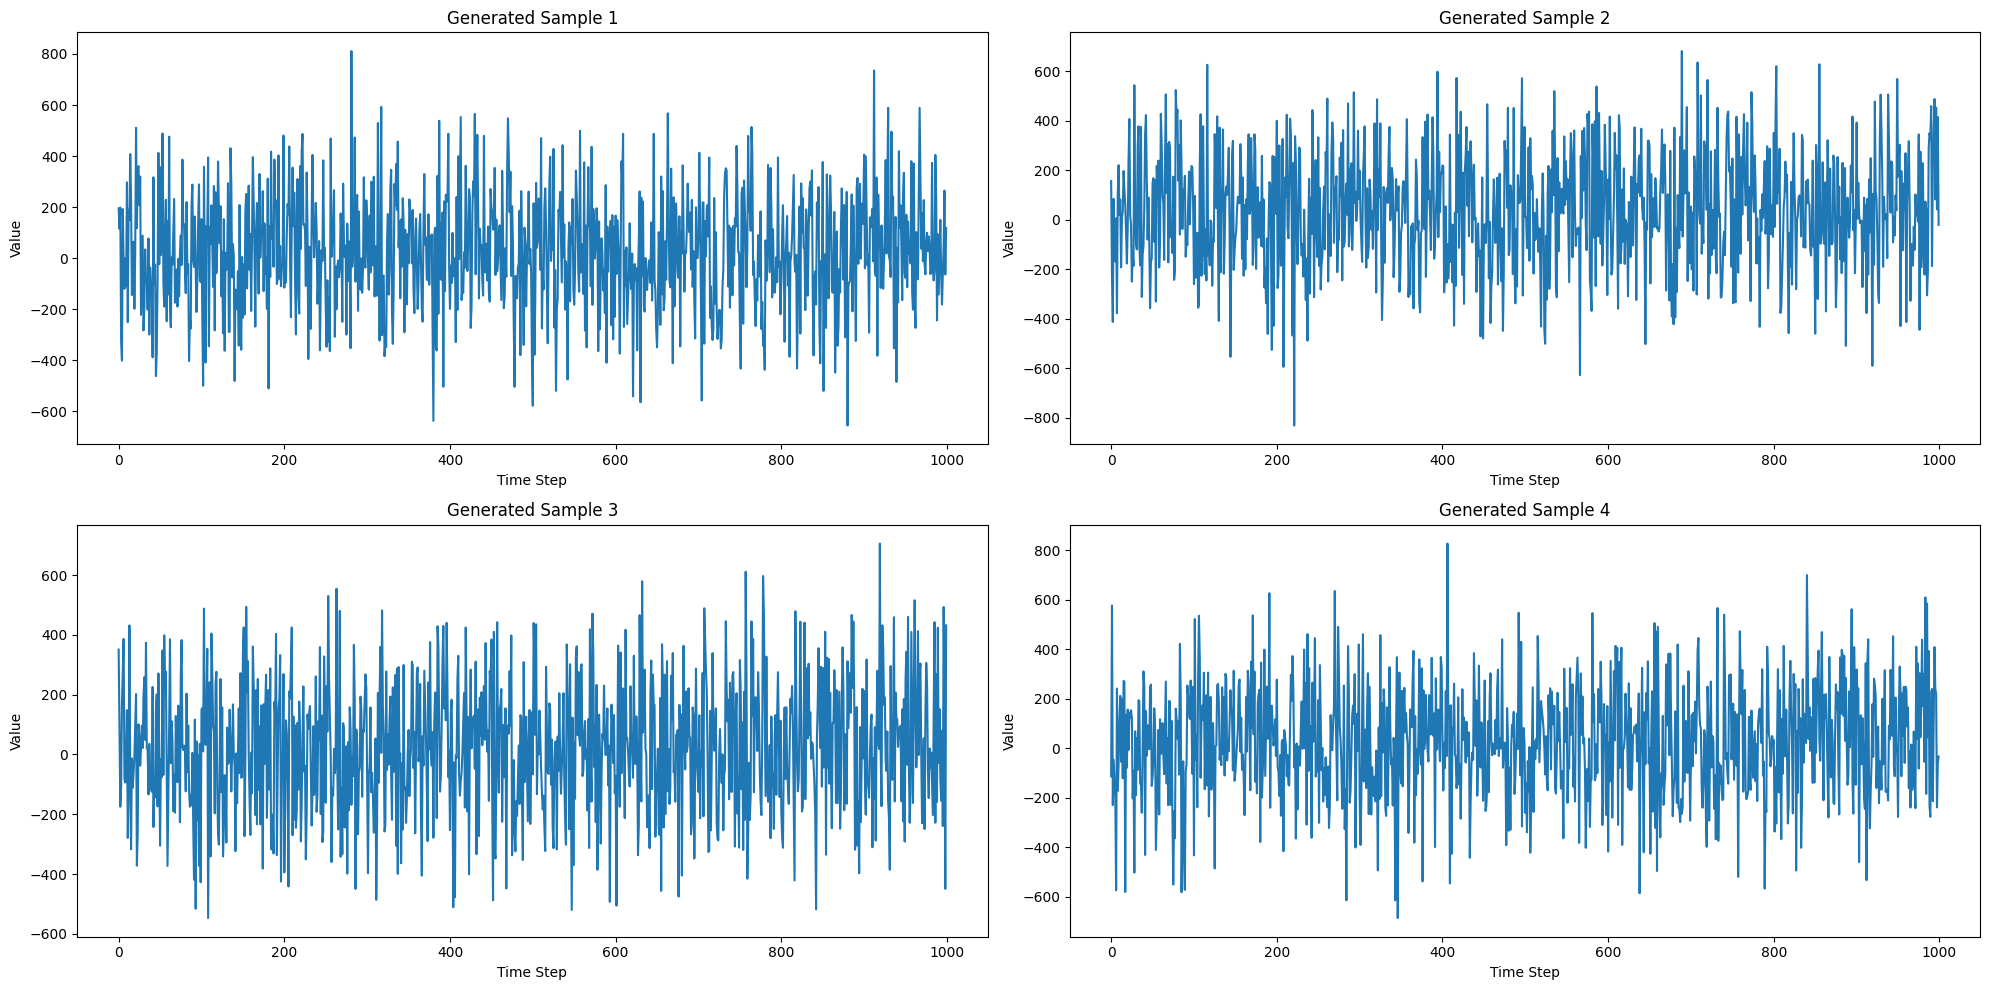

Epoch 0: : 0it [06:01, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 1: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 2: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 3: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 4: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Sampling: 100%|██████████| 1001/1001 [06:00<00:00,  2.78it/s]


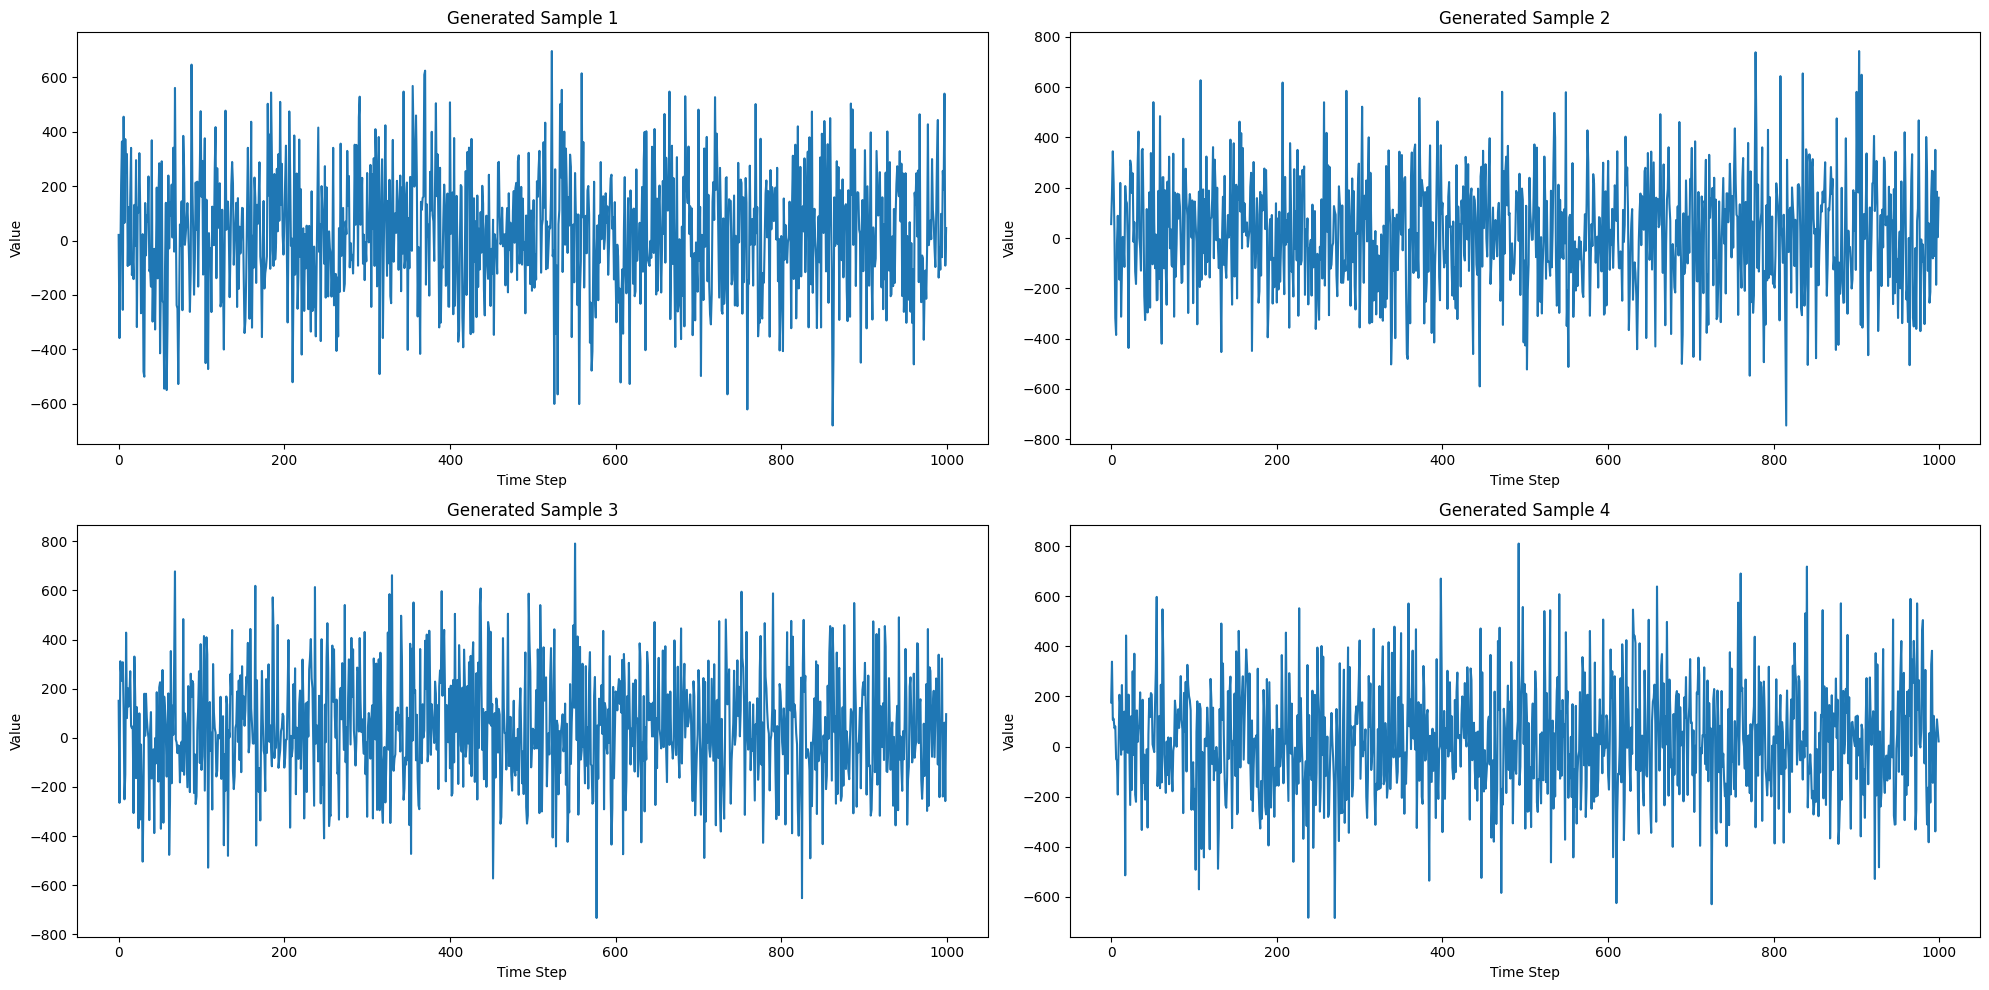

Epoch 5: : 0it [06:01, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 6: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 7: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 8: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Sampling: 100%|██████████| 1001/1001 [06:01<00:00,  2.77it/s]


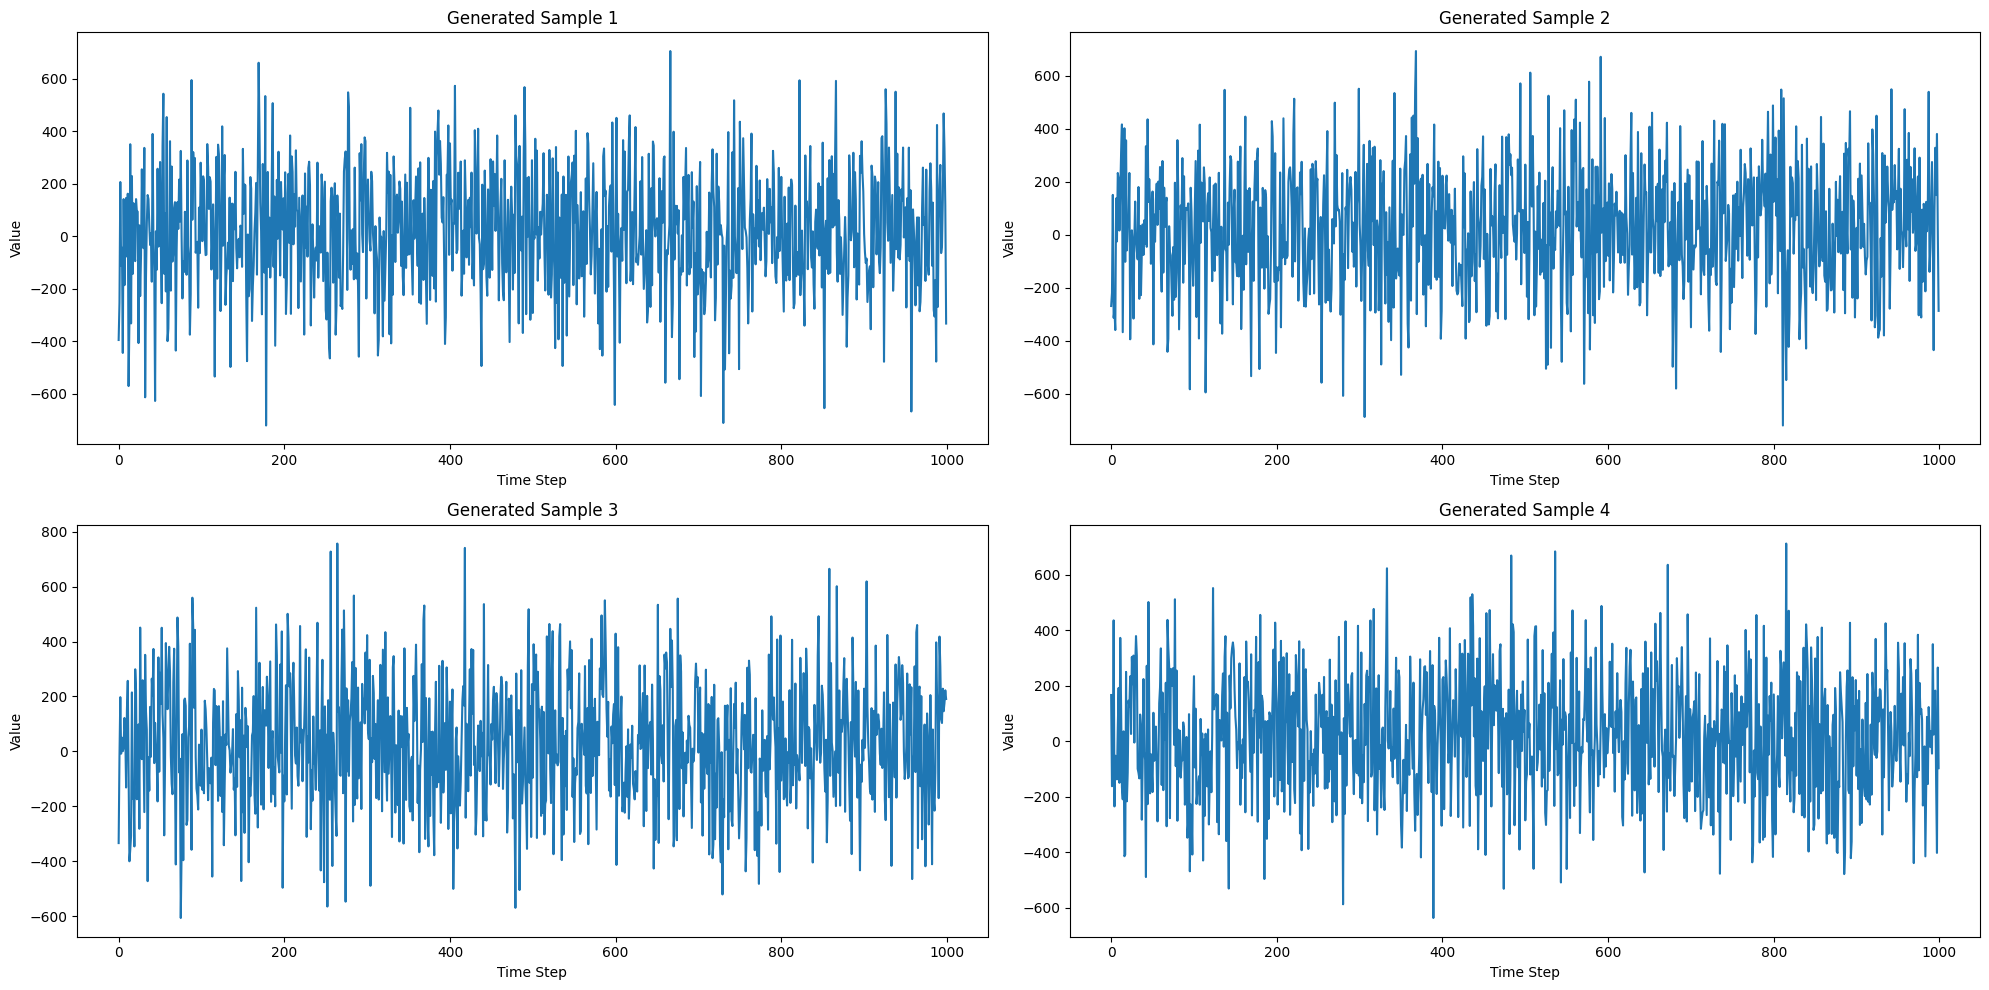

Epoch 9: : 0it [06:02, ?it/s]


In [69]:
sequence_length = 1000
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        
        """order proposed by claude --- to verify 
        loss = nn.MSELoss()(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() 
        """
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
    # Evaluation and visualization
    if epoch % 5 == 0 or epoch == config.num_epochs - 1:
        model.eval()
        eval_batch_size = config.eval_batch_size
        sample = torch.randn(eval_batch_size, sequence_length)
        timesteps = list(range(noise_scheduler.num_timesteps))[::-1]

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
                time_tensor = torch.full((eval_batch_size,), t, device=sample.device, dtype=torch.long)
                residual = model(sample, time_tensor)
                sample = noise_scheduler.step(residual, time_tensor[0], sample)
    
    # Visualize the generated samples
        fig, axs = plt.subplots(2, 2, figsize=(20, 10))
        for i in range(min(4, eval_batch_size)):
            ax = axs[i // 2, i % 2]
            ax.plot(sample[i].cpu().numpy())
            ax.set_title(f"Generated Sample {i+1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
        
        plt.tight_layout()
        plt.show()
        
    progress_bar.close()


## Ajout de buit incrémentalement:

Training model...


0it [00:00, ?it/s]:00, ?it/s]
Sampling: 100%|██████████| 1001/1001 [06:00<00:00,  2.78it/s]


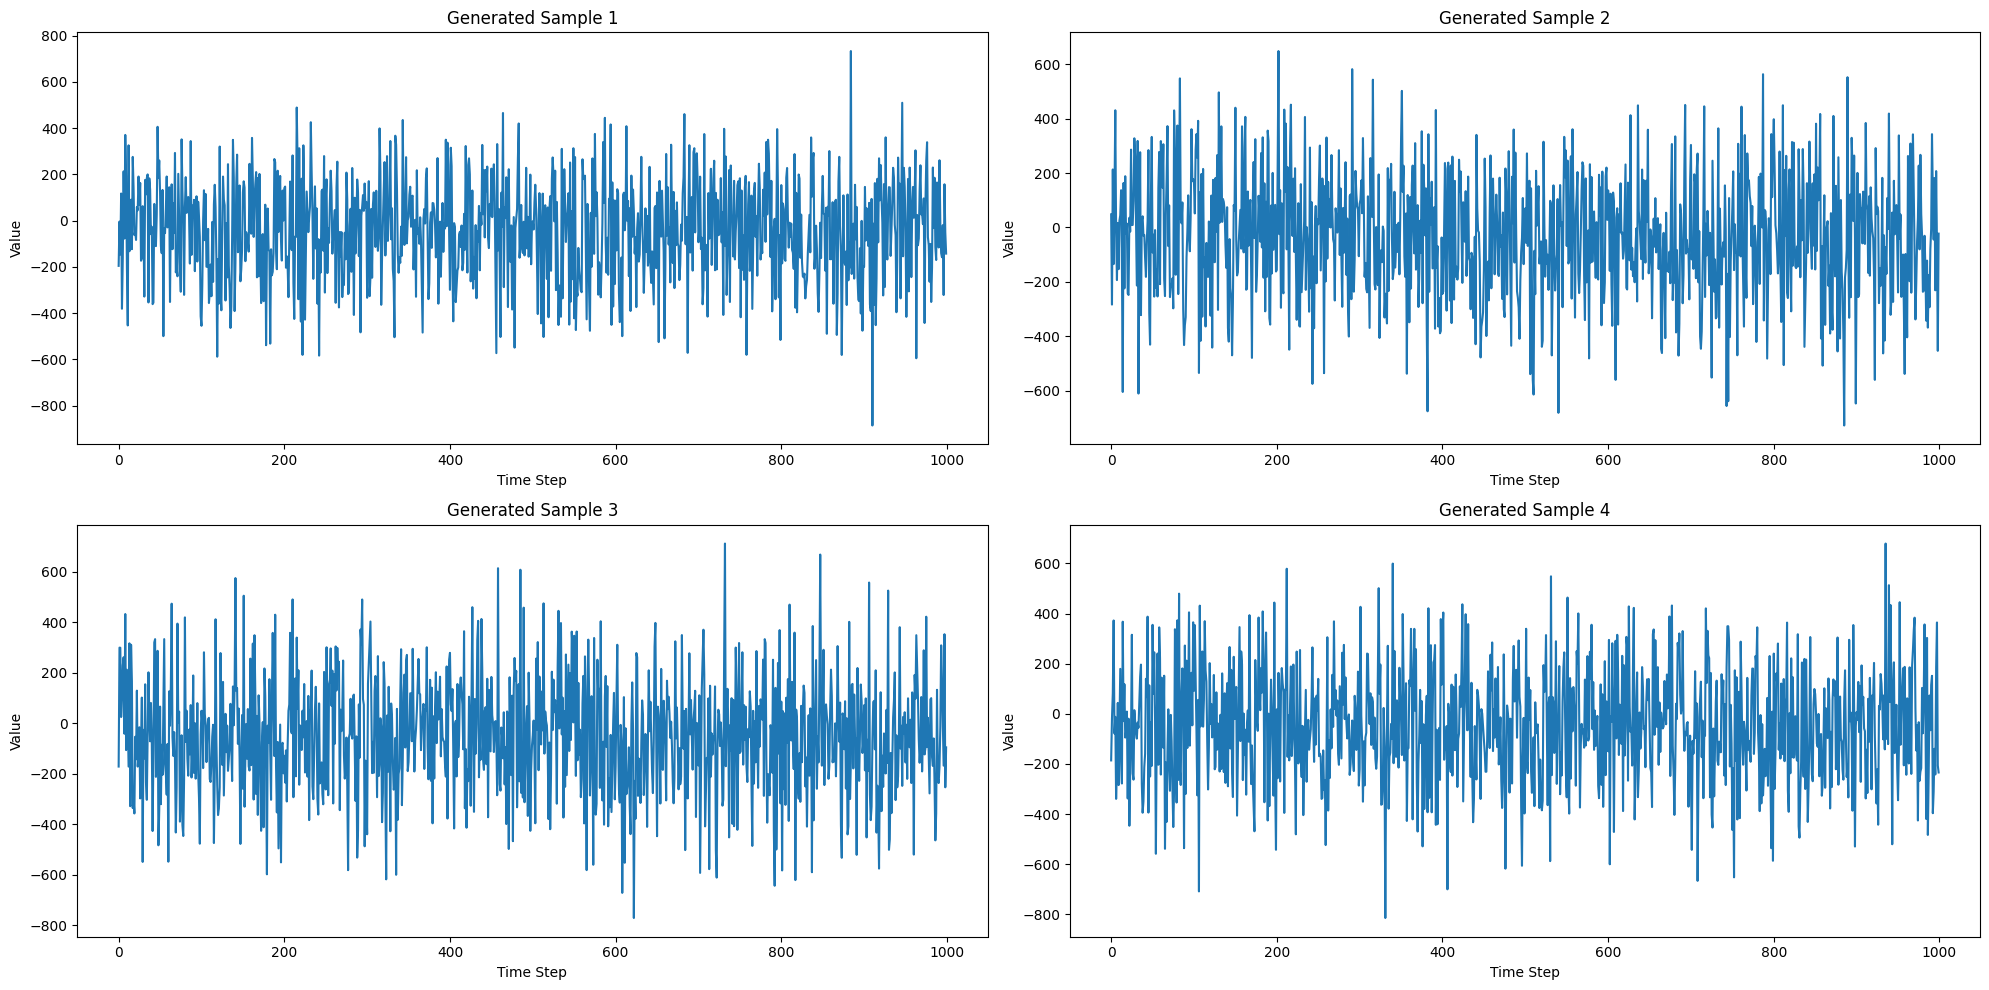

Epoch 0: : 0it [06:01, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 1: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 2: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 3: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Epoch 4: : 0it [00:00, ?it/s]
0it [00:00, ?it/s]:00, ?it/s]
Sampling:   3%|▎         | 28/1001 [00:10<06:04,  2.67it/s]


KeyboardInterrupt: 

In [70]:
sequence_length = 1000
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
         # Generate incremental and ordered timesteps for each batch
        timesteps = torch.linspace(
            0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]
        ).long()
        
        print('timesteps', timesteps)
        
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        
        """order proposed by claude --- to verify 
        loss = nn.MSELoss()(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() 
        """
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
    # Evaluation and visualization
    if epoch % 5 == 0 or epoch == config.num_epochs - 1:
        model.eval()
        eval_batch_size = config.eval_batch_size
        sample = torch.randn(eval_batch_size, sequence_length)
        timesteps = list(range(noise_scheduler.num_timesteps))[::-1]

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
                time_tensor = torch.full((eval_batch_size,), t, device=sample.device, dtype=torch.long)
                residual = model(sample, time_tensor)
                sample = noise_scheduler.step(residual, time_tensor[0], sample)
    
    # Visualize the generated samples
        fig, axs = plt.subplots(2, 2, figsize=(20, 10))
        for i in range(min(4, eval_batch_size)):
            ax = axs[i // 2, i % 2]
            ax.plot(sample[i].cpu().numpy())
            ax.set_title(f"Generated Sample {i+1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
        
        plt.tight_layout()
        plt.show()
        
    progress_bar.close()
